# Testing SAM Model

In [1]:
#import cv2
!pip install customtkinter
!pip install segment-anything
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/n_/v62t5pf91cv588s9cqjq16dh0000gn/T/pip-req-build-qo9j6x2w
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/n_/v62t5pf91cv588s9cqjq16dh0000gn/T/pip-req-build-qo9j6x2w
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [2]:
import os
import matplotlib.pyplot as plt
import platform
import numpy as np
#import torch
import matplotlib.pyplot as plt
import cv2
import tkinter as tk
import customtkinter as ctk

In [27]:
path = r'/Users/mattracz/Downloads/chillcat 2.jpeg' 

assert path is not None, "No file selected"

image = plt.imread(path)

#plt.imshow(image)

#if file doesnt exist error, say "file not found" else imshow

In [69]:
ctk.set_appearance_mode("Dark")
ctk.set_default_color_theme("blue")

root = ctk.CTk()

In [70]:
def delete_mask():
    pass

root.title("SAM Model")
root.geometry("1500x1000")
delete_mask_button = ctk.CTkButton(root, 
                       text="Delete Stuff",
                       height=100,
                       width = 400,
                       font=("Helvetica", 50),
                       text_color="black",
                       fg_color="red",
                       hover_color="#aa0000",
                       corner_radius = 15,
                       command=delete_mask,

                       )
delete_mask_button.pack()

In [71]:
value_entry = ctk.CTkEntry(root,
                           placeholder_text="Value",
                           height=60,
                           width=90,
                           font=("Times New Roman", 18))
value_entry.pack(pady=40)

In [72]:
def submit_value():
    text = f'{delete_button.get()}'

def delete_value():
    value_entry.delete(0, "end")

delete_button = ctk.CTkButton(root,
                             text="delete box",
                             command=delete_value)
delete_button.pack()

In [73]:
root.mainloop()

(np.float64(-0.5), np.float64(1413.5), np.float64(1270.5), np.float64(-0.5))

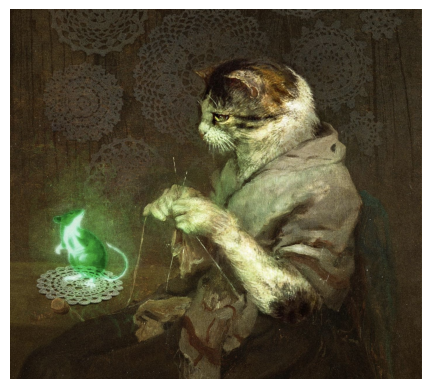

In [9]:
plt.figure() #figsize=(20, 20)
plt.imshow(image)
plt.plot()
plt.axis('off')

In [10]:
def show_anns(anns):
    if len(anns)==0: return
    sorted_anns = sorted(anns, key=['area'], reverse=True)
    #take all of SAM's generated masks, make sorted array of annotations in row 0, and their sizes in row 1
    layers = 4
    img = [sorted_anns[0]['segmentation'].shape[0]][sorted_anns[0]['segmentation'].shape[1]][layers]
    img = np.ones(img)
    img[:,:,3] = 0
    #X many layers to array
    #array2 = np.ones(array)
    base_color = 0.35
    for ann in sorted_anns:
        img[ann['segmentation']] = (color_mask:= np.concatenate(np.random.random(3), [base_color]).tolist()[0])
    print(color_mask)
    #for anns['segmentation'] in anns, array2 concat(np.random.random(3), [float between 0 and 1])
    #array[anns['segmentation']] = color_mask

In [11]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry,  SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator( #eventually, set to user's values
    model=sam,
    points_per_side=20,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.7,
    crop_n_layers=0,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=100

)
masks = mask_generator.generate(image)

ModuleNotFoundError: No module named 'torch'

NameError: name 'masks' is not defined

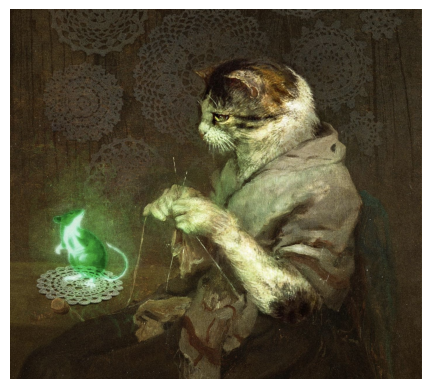

In [ ]:
#plt.figure() #figsize=(20, 20)
#plt.imshow(image)
#plt.plot()
#plt.axis('off')

plt.figure()
plt.imshow(image)
plt.axis('off')
show_anns(masks)
plt.show() 